In [2]:
import pandas as pd

porosity_df = pd.read_csv('linear_dependency.csv')

In [6]:
print(porosity_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & d_param & porosity_Schwarz_p & porosity_Gyroid \\
\midrule
0 & -0.985086 & 0.796602 & 0.806768 \\
1 & -0.834337 & 0.777147 & 0.831175 \\
2 & -0.602925 & 0.759682 & 0.859706 \\
3 & -0.357099 & 0.730533 & 0.887477 \\
4 & -0.350885 & 0.730399 & 0.887931 \\
5 & -0.262321 & 0.707480 & 0.896708 \\
6 & -0.086151 & 0.681178 & 0.995867 \\
7 & 0.184648 & 0.667845 & 0.989362 \\
8 & 0.429486 & 0.689464 & 0.989704 \\
9 & 0.446178 & 0.685388 & 0.992671 \\
10 & 0.465395 & 0.690117 & 0.991798 \\
11 & 0.583936 & 0.671619 & 0.984828 \\
12 & 0.642550 & 0.664104 & 0.975655 \\
13 & 0.713229 & 0.670550 & 0.974905 \\
14 & 0.721315 & 0.666064 & 0.980358 \\
15 & 0.778426 & 0.673395 & 0.975438 \\
16 & 0.867778 & 0.680311 & 0.979937 \\
17 & 0.873779 & 0.671111 & 0.980480 \\
18 & 0.953246 & 0.686131 & 0.995606 \\
19 & 0.959561 & 0.686817 & 0.996571 \\
\bottomrule
\end{tabular}



In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

import numpy as np

In [13]:
x = porosity_df['d_param'].values.reshape(-1,1)
y = porosity_df['porosity_Schwarz_p'].values
x.shape

(20, 1)

In [17]:
degree = 3

x_poly = PolynomialFeatures(degree=degree).fit_transform(x)
print(x_poly.shape)
linear = LinearRegression()
linear.fit(x_poly, y)
y_pred = linear.predict(x_poly)
mse(y, y_pred)
print(linear.coef_)

(20, 4)
[ 0.         -0.06816784  0.04984266  0.01013945]


In [18]:
import matplotlib.pyplot as plt

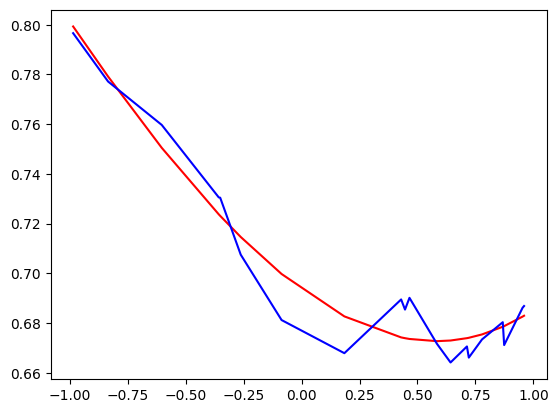

In [19]:
plt.plot(x, y_pred, c='red')
plt.plot(x, y, c='blue')